In [16]:
import brainbox
from one.api import ONE
from utils import download_glm_hmm, save_data_path, val_eid

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches

import phate
import scprep

In [2]:
# Loading up the cleaned data
data = pd.read_pickle('data/ephys_glm_frame_data.pkl')
data.shape

(29023, 31)

In [3]:
# add a column for the signed contrast (right - left). 
# if nan, treat it as 0
data["signed_contrast"] = data["contrastRight"].fillna(0) - data["contrastLeft"].fillna(0)

In [4]:
data.columns

Index(['stimOnTrigger_times', 'repNum', 'goCueTrigger_times',
       'quiescencePeriod', 'contrastLeft', 'stimOn_times', 'feedback_times',
       'probabilityLeft', 'response_times', 'rewardVolume', 'choice',
       'goCue_times', 'firstMovement_times', 'contrastRight', 'feedbackType',
       'session', 'stimOff_times', 'glm-hmm_5', 'glm-hmm_3', 'glm-hmm_2',
       'glm-hmm_4', 'intervals_0', 'intervals_1', 'intervals_bpod_0',
       'intervals_bpod_1', 'subject', 'included', 'trial_idx', 'frame_preds',
       'frame_start_index', 'frame_end_index', 'signed_contrast'],
      dtype='object')

In [92]:
def count_max_prob_classes(frame_predictions):
    # Find the index of the max probability in each row
    max_indices = np.argmax(frame_predictions, axis=1)
    
    # Count occurrences of each index
    counts = np.bincount(max_indices, minlength=4)
    
    # Map counts to class names
    class_names = ["still", "move", "wheel_turn", "groom"]
    count_dict = {class_names[i]: counts[i] for i in range(4)}
    
    return count_dict

In [93]:
adf = pd.DataFrame()

for sess_id in val_eid:
    # Get the data for the session
    sess_data = data[data['session'] == sess_id]
    
    # for every trial of this session, get the frame predictions
    for i in range(len(sess_data)):
        # Get the data for this trial
        trial_data = sess_data.iloc[i]
        
        # Get the frame predictions
        frame_predictions = trial_data['frame_preds']

        # Count the number of occurrences of each class
        count_dict = count_max_prob_classes(frame_predictions)

        # get the 3 state state model
        state_model = trial_data['glm-hmm_4']

        # rest of the columns
        rest = trial_data[[
            'session', 'trial_idx', 'signed_contrast',
            'stimOnTrigger_times', 'repNum', 'goCueTrigger_times',
            'quiescencePeriod', 'contrastLeft', 'stimOn_times', 'feedback_times',
            'probabilityLeft', 'response_times', 'rewardVolume', 'choice',
            'goCue_times', 'firstMovement_times', 'contrastRight', 'feedbackType',
            'stimOff_times', 'intervals_0', 'intervals_1', 'intervals_bpod_0',
            'intervals_bpod_1', 'subject', 'included',
            'frame_start_index', 'frame_end_index']]

        # store them in the dataframe
        adf = pd.concat([adf, pd.DataFrame({
            "state_1": [state_model[0]],
            "state_2": [state_model[1]],
            "state_3": [state_model[2]],
            "state_4": [state_model[3]],
            "most_likely_state": [['state_1', 'state_2', 'state_3', 'state_4'][np.argmax(state_model)]],
            **count_dict,
            **rest.to_dict()
        })])


In [7]:
adf[[ 'session', 'signed_contrast', 'choice', 'state_1', 'state_2', 'state_3', 'state_4', 'most_likely_state']].head(20)

,session,signed_contrast,choice,state_1,state_2,state_3,state_4,most_likely_state
0,db4df448-e449-4a6f-a0e7-288711e7a75a,1.0000,-1.0,0.004913,0.663200,0.331887,4.243582e-11,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,-0.2500,1.0,0.003299,0.691609,0.304923,1.688919e-04,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,0.2500,-1.0,0.002035,0.722781,0.274390,7.940015e-04,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,0.1250,-1.0,0.002052,0.750469,0.246097,1.382146e-03,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,0.2500,-1.0,0.002479,0.773242,0.222289,1.989782e-03,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,1.0000,-1.0,0.003446,0.795253,0.198662,2.639445e-03,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,-0.0625,-1.0,0.004534,0.817636,0.174533,3.297173e-03,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,-1.0000,1.0,0.005611,0.817898,0.172844,3.647671e-03,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,-0.1250,-1.0,0.006654,0.818516,0.170424,4.404793e-03,state_2
0,db4df448-e449-4a6f-a0e7-288711e7a75a,0.1250,-1.0,0.008039,0.750109,0.237760,4.091719e-03,state_2


In [8]:
from brainbox.behavior.training import get_signed_contrast, compute_performance, compute_psychometric, plot_psychometric
import psychofit as psy

compute_psychometric details
```
def compute_psychometric(trials, signed_contrast=None, block=None, plotting=False, compute_ci=False, alpha=.032):
    
    Compute psychometric fit parameters for trials object.

    Parameters
    ----------
    trials : one.alf.io.AlfBunch
        An ALF trials object containing the keys {'probabilityLeft', 'contrastLeft',
        'contrastRight', 'feedbackType', 'choice', 'response_times', 'stimOn_times'}.
    signed_contrast : numpy.array
        An array of signed contrasts in percent the length of trials, where left contrasts are -ve.
        If None, these are computed from the trials object.
    block : float
        The block type to compute. If None, all trials are included, otherwise only trials where
        probabilityLeft matches this value are included.  For biasedChoiceWorld, the
        probabilityLeft set is {0.5, 0.2, 0.8}.
    plotting : bool
        Which set of psychofit model parameters to use (see notes).
    compute_ci : bool
        If true, computes and returns the confidence intervals for response at each contrast.
    alpha : float, default=0.032
        Significance level for confidence interval. Must be in (0, 1). If `compute_ci` is false,
        this value is ignored.

    Returns
    -------
    numpy.array
        Array of psychometric fit parameters - bias, threshold, lapse high, lapse low.
    (tuple of numpy.array)
        If `compute_ci` is true, a tuple of

    See Also
    --------
    statsmodels.stats.proportion.proportion_confint - The function used to compute confidence
      interval.
    psychofit.mle_fit_psycho - The function used to fit the psychometric parameters.

    Notes
    -----
    The psychofit starting parameters and model constraints used for the fit when computing the
    training status (e.g. trained_1a, etc.) are sub-optimal and can produce a poor fit. To keep
    the precise criteria the same for all subjects, these parameters have not changed. To produce a
    better fit for plotting purposes, or to calculate the training status in a manner inconsistent
    with the IBL training pipeline, use plotting=True.
    
```

In [9]:
# seperate the data by most likely state
state_1 = adf[adf['most_likely_state'] == 'state_1']
state_2 = adf[adf['most_likely_state'] == 'state_2']
state_3 = adf[adf['most_likely_state'] == 'state_3']
state_4 = adf[adf['most_likely_state'] == 'state_4']

In [10]:
contrasts_fit = np.arange(-100, 100)
block = None

state_1_prob_right, state_1_contrasts, _ = compute_performance(state_1, signed_contrast=None, block=block, prob_right=True)
state_1_psy, state_1_ci = compute_psychometric(trials=state_1, signed_contrast=None, block=block, plotting=True, compute_ci=True, alpha=0.32)
state_1_fit_line = psy.erf_psycho_2gammas(state_1_psy, contrasts_fit)

state_2_prob_right, state_2_contrasts, _ = compute_performance(state_2, signed_contrast=None, block=block, prob_right=True)
state_2_psy, state_2_ci = compute_psychometric(trials=state_2, signed_contrast=None, block=block, plotting=True, compute_ci=True, alpha=0.32)
state_2_fit_line = psy.erf_psycho_2gammas(state_2_psy, contrasts_fit)

state_3_prob_right, state_3_contrasts, _ = compute_performance(state_3, signed_contrast=None, block=block, prob_right=True)
state_3_psy, state_3_ci = compute_psychometric(trials=state_3, signed_contrast=None, block=block, plotting=True, compute_ci=True, alpha=0.32)
state_3_fit_line = psy.erf_psycho_2gammas(state_3_psy, contrasts_fit)

state_4_prob_right, state_4_contrasts, _ = compute_performance(state_4, signed_contrast=None, block=block, prob_right=True)
state_4_psy, state_4_ci = compute_psychometric(trials=state_4, signed_contrast=None, block=block, plotting=True, compute_ci=True, alpha=0.32)
state_4_fit_line = psy.erf_psycho_2gammas(state_4_psy, contrasts_fit)

In [11]:
# state colors from now on -> ["#DB504A", "#E3B505", "#4F6D7A", "#56A3A6"]

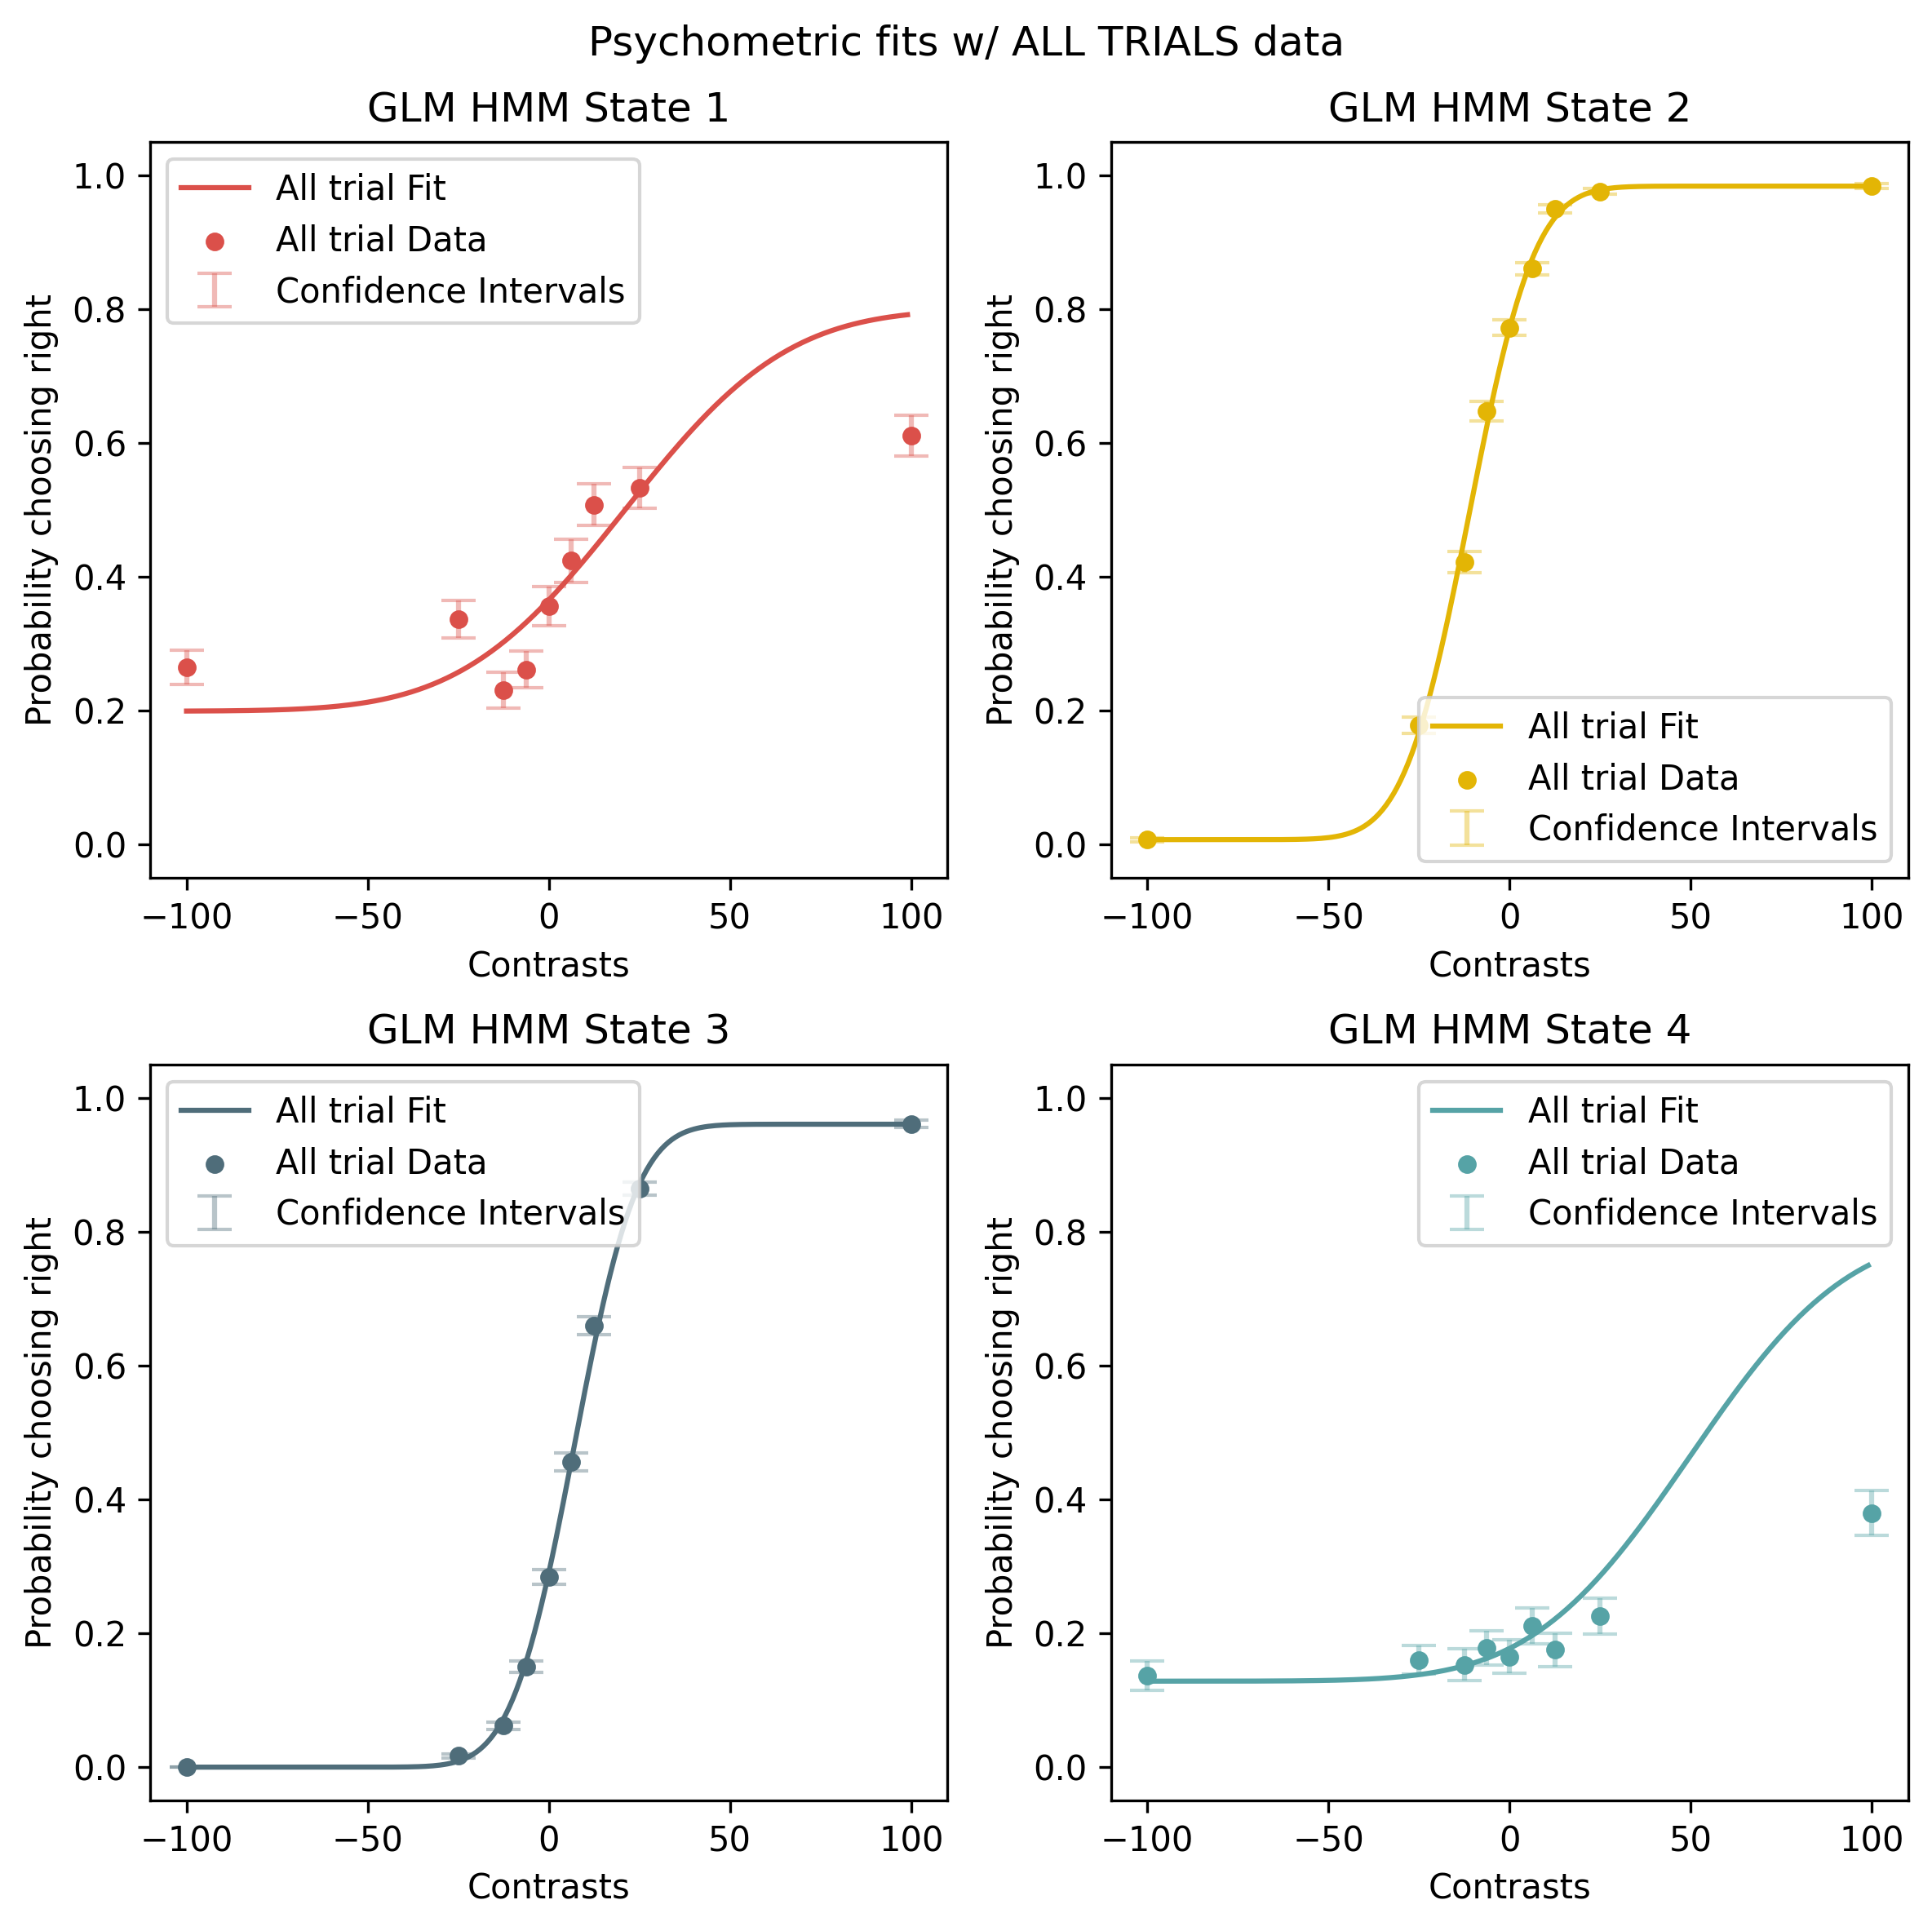

In [17]:
cmap = ["#DB504A", "#E3B505", "#4F6D7A", "#56A3A6"]

# make 1x4 plot
fig, ax = plt.subplots(2,2, figsize=(8, 8), dpi=300)

for i, (state_prob_right, state_contrasts, state_fit_line, state_ci, state_psy, state) in enumerate([
    (state_1_prob_right, state_1_contrasts, state_1_fit_line, state_1_ci, state_1_psy, 'State 1'),
    (state_2_prob_right, state_2_contrasts, state_2_fit_line, state_2_ci, state_2_psy, 'State 2'),
    (state_3_prob_right, state_3_contrasts, state_3_fit_line, state_3_ci, state_3_psy, 'State 3'),
    (state_4_prob_right, state_4_contrasts, state_4_fit_line, state_4_ci, state_4_psy, 'State 4')
]):
    # fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    line_ax = ax[i//2, i%2].plot(contrasts_fit, state_fit_line, color=cmap[i])
    scatt_ax = ax[i//2, i%2].scatter(state_contrasts, state_prob_right, color=cmap[i], s=20)

    errbar = np.c_[np.abs(state_ci[0]), np.abs(state_ci[1])].T
    
    err_ax = ax[i//2, i%2].errorbar(state_contrasts, state_prob_right, yerr=errbar, ecolor=cmap[i], fmt='none', capsize=5, alpha=0.4)

    ax[i//2, i%2].legend(["All trial Fit", "All trial Data", "Confidence Intervals"])
    ax[i//2, i%2].set_ylim(-0.05, 1.05)
    ax[i//2, i%2].set_ylabel('Probability choosing right')
    ax[i//2, i%2].set_xlabel('Contrasts')
    ax[i//2, i%2].set_title("GLM HMM "+state)
# add some vertical space and add a suptitle
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Psychometric fits w/ ALL TRIALS data")
plt.show()


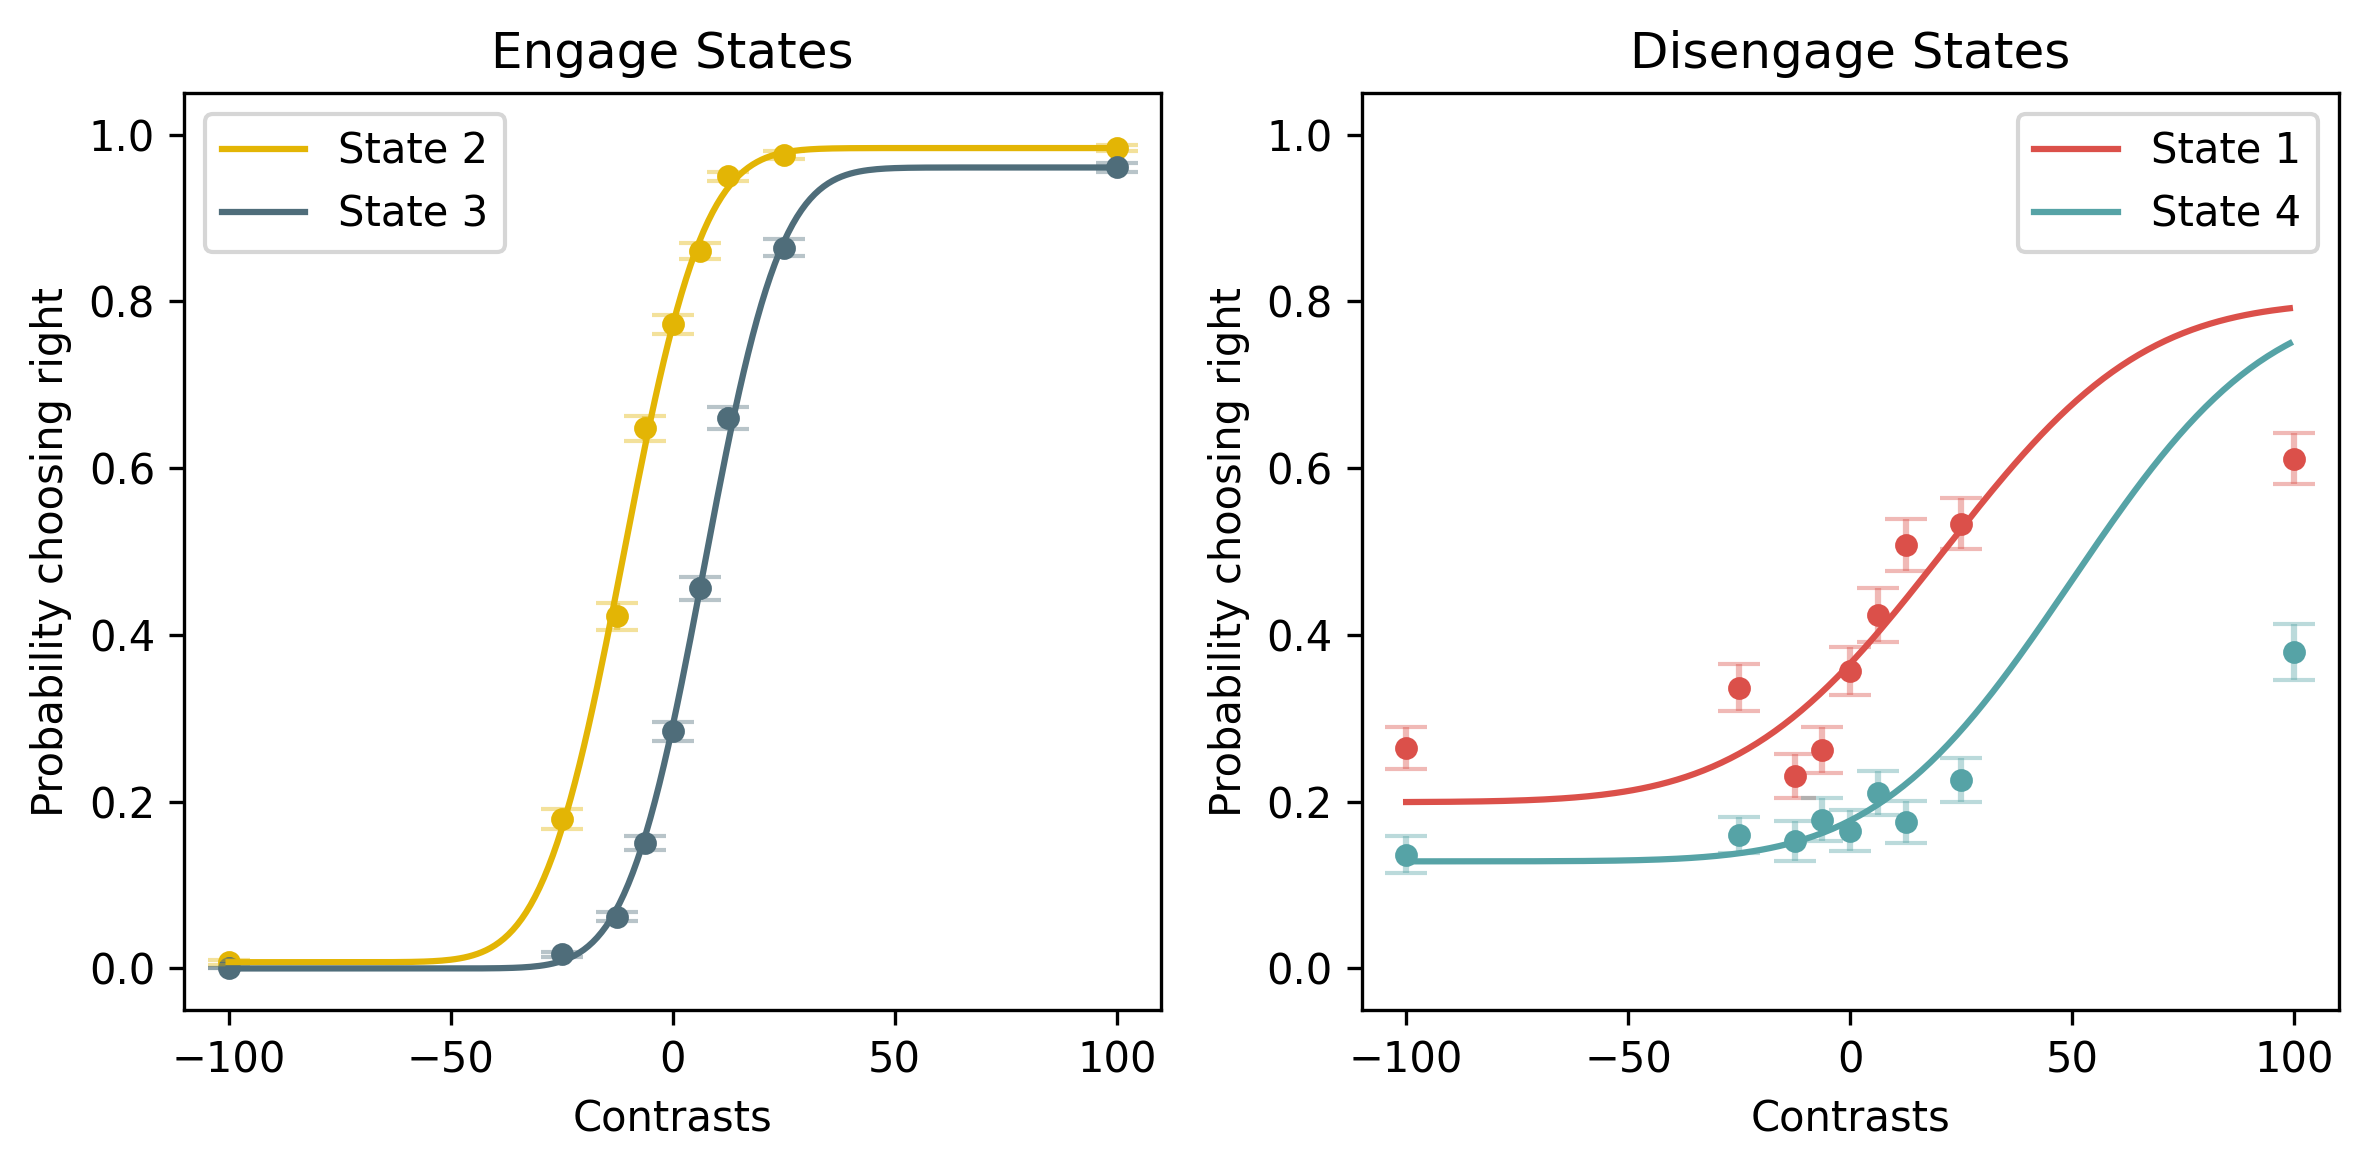

In [22]:
# Plot the 2 engage and 2 disengage states together
# State 2 and 3 are engage states
# State 1 and 4 are disengage states

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

# Engage states
line_ax = ax[0].plot(contrasts_fit, state_2_fit_line, color=cmap[1], label="State 2")
scatt_ax = ax[0].scatter(state_2_contrasts, state_2_prob_right, color=cmap[1], s=20)

errbar = np.c_[np.abs(state_2_ci[0]), np.abs(state_2_ci[1])].T
err_ax = ax[0].errorbar(state_2_contrasts, state_2_prob_right, yerr=errbar, ecolor=cmap[1], fmt='none', capsize=5, alpha=0.4)

line_ax = ax[0].plot(contrasts_fit, state_3_fit_line, color=cmap[2], label="State 3")
scatt_ax = ax[0].scatter(state_3_contrasts, state_3_prob_right, color=cmap[2], s=20)

errbar = np.c_[np.abs(state_3_ci[0]), np.abs(state_3_ci[1])].T
err_ax = ax[0].errorbar(state_3_contrasts, state_3_prob_right, yerr=errbar, ecolor=cmap[2], fmt='none', capsize=5, alpha=0.4)

ax[0].legend()
ax[0].set_ylim(-0.05, 1.05)
ax[0].set_ylabel('Probability choosing right')
ax[0].set_xlabel('Contrasts')
ax[0].set_title("Engage States")

# Disengage states
line_ax = ax[1].plot(contrasts_fit, state_1_fit_line, color=cmap[0], label="State 1")
scatt_ax = ax[1].scatter(state_1_contrasts, state_1_prob_right, color=cmap[0], s=20)

errbar = np.c_[np.abs(state_1_ci[0]), np.abs(state_1_ci[1])].T
err_ax = ax[1].errorbar(state_1_contrasts, state_1_prob_right, yerr=errbar, ecolor=cmap[0], fmt='none', capsize=5, alpha=0.4)

line_ax = ax[1].plot(contrasts_fit, state_4_fit_line, color=cmap[3], label="State 4")
scatt_ax = ax[1].scatter(state_4_contrasts, state_4_prob_right, color=cmap[3], s=20)

errbar = np.c_[np.abs(state_4_ci[0]), np.abs(state_4_ci[1])].T
err_ax = ax[1].errorbar(state_4_contrasts, state_4_prob_right, yerr=errbar, ecolor=cmap[3], fmt='none', capsize=5, alpha=0.4)

ax[1].legend()
ax[1].set_ylim(-0.05, 1.05)
ax[1].set_ylabel('Probability choosing right')
ax[1].set_xlabel('Contrasts')
ax[1].set_title("Disengage States")

plt.tight_layout()
# plt.subplots_adjust(top=0.92)
# plt.suptitle("Psychometric fits w/ ALL TRIALS data")
plt.show()

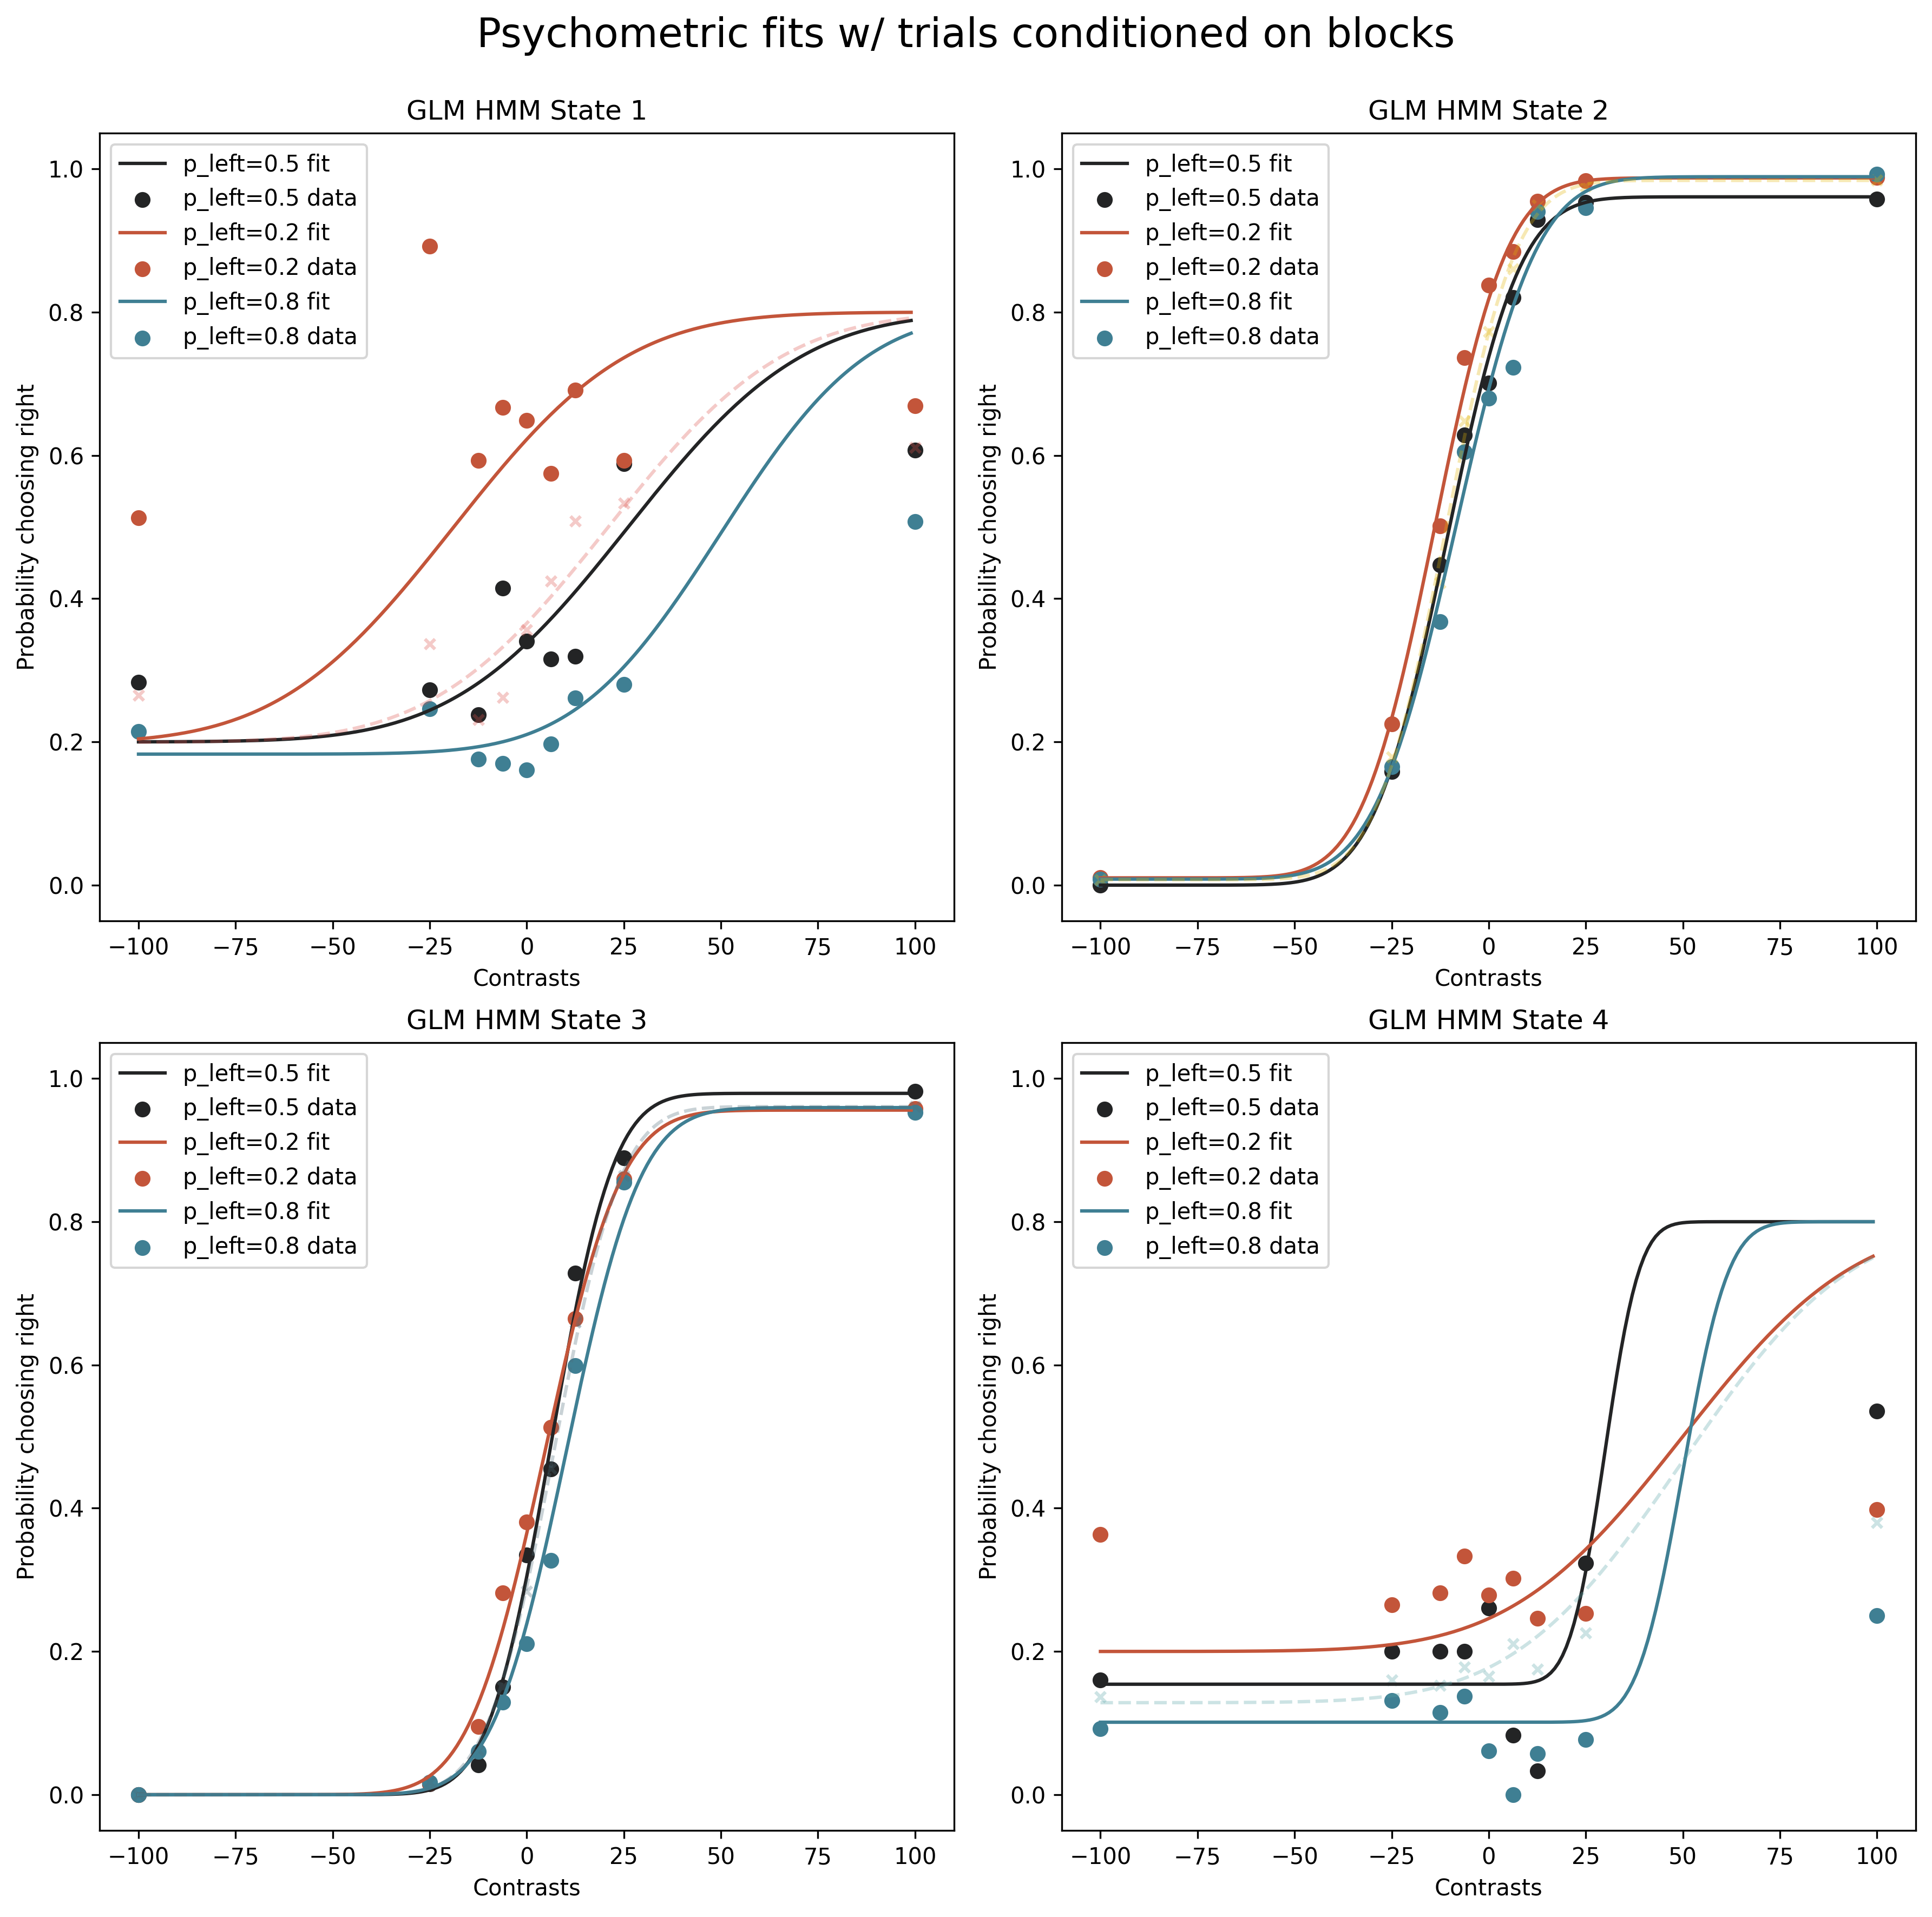

In [23]:
# make the same above plot in 2x2 instead of 1x4
scale = 1.5
fig, ax = plt.subplots(2, 2, figsize=(8*scale, 8*scale), dpi=300)

for i, state_data in enumerate([state_1, state_2, state_3, state_4]):
    plot_psychometric(state_data, ax=ax[i//2, i%2], title=f"GLM HMM State {i+1}", plot_ci=False, ci_alpha=0.032)

for i, (state_prob_right, state_contrasts, state_fit_line, state) in enumerate([
    (state_1_prob_right, state_1_contrasts, state_1_fit_line, 'State 1'),
    (state_2_prob_right, state_2_contrasts, state_2_fit_line, 'State 2'),
    (state_3_prob_right, state_3_contrasts, state_3_fit_line, 'State 3'),
    (state_4_prob_right, state_4_contrasts, state_4_fit_line, 'State 4')
]):
    # fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    line_ax = ax[i//2, i%2].plot(contrasts_fit, state_fit_line, '--', color=cmap[i], alpha=0.3, label="All trials Fit")
    scatt_ax = ax[i//2, i%2].scatter(state_contrasts, state_prob_right, color=cmap[i], s=20, marker='x', alpha=0.3, label="All trials Data")

    ax[i//2, i%2].set_ylim(-0.05, 1.05)
    ax[i//2, i%2].set_ylabel('Probability choosing right')
    ax[i//2, i%2].set_xlabel('Contrasts')
    ax[i//2, i%2].set_title("GLM HMM "+state)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Psychometric fits w/ trials conditioned on blocks", fontsize=18)
plt.show()

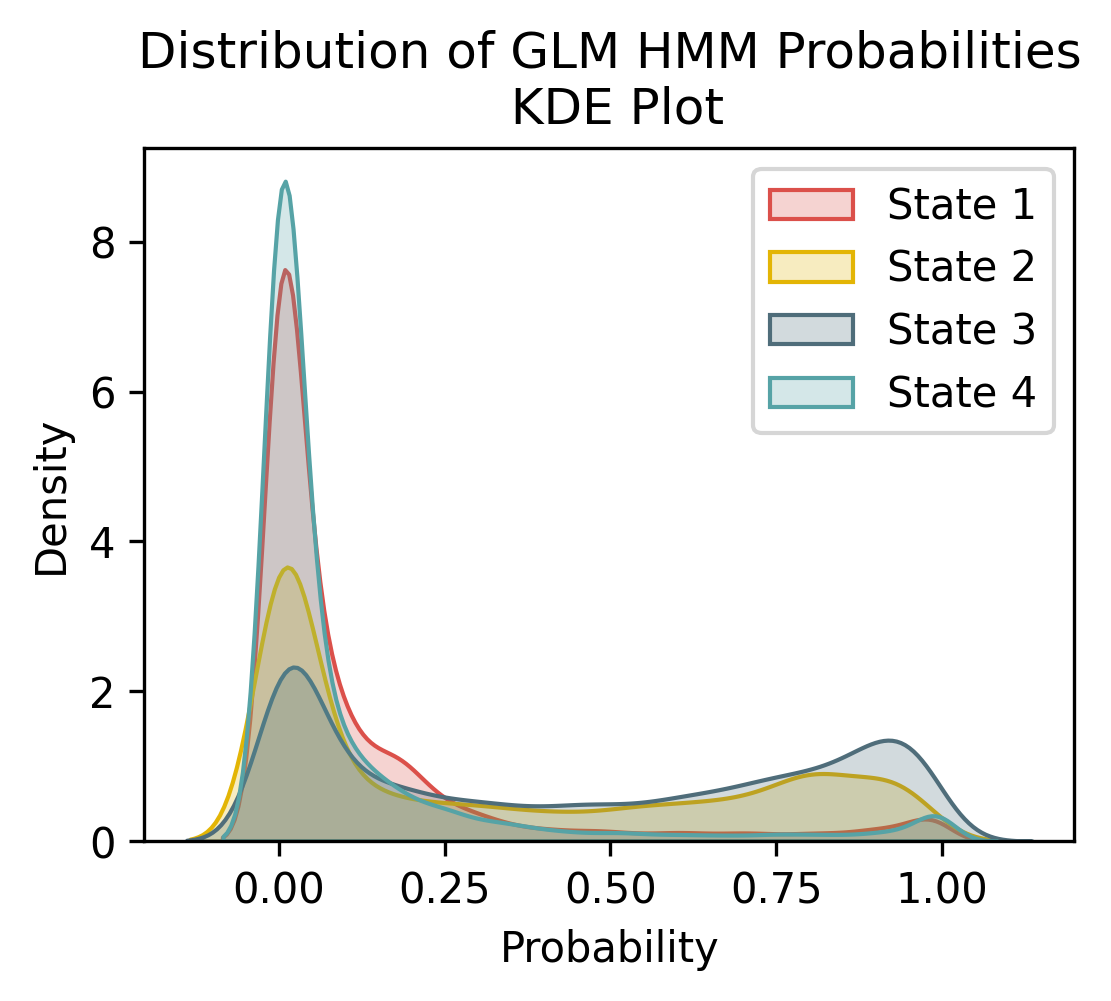

In [ ]:
# plot the fractional occupancy of each state
plt.figure(figsize=(4, 3), dpi=300)
sns.kdeplot(adf['state_1'], color=cmap[0], label='State 1', shade=True)
sns.kdeplot(adf['state_2'], color=cmap[1], label='State 2', shade=True)
sns.kdeplot(adf['state_3'], color=cmap[2], label='State 3', shade=True)
sns.kdeplot(adf['state_4'], color=cmap[3], label='State 4', shade=True)
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Distribution of GLM HMM Probabilities\n w/ Kernel density estimate (KDE)')
plt.legend()
plt.show()

/tmp/ipykernel_24662/72894960.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


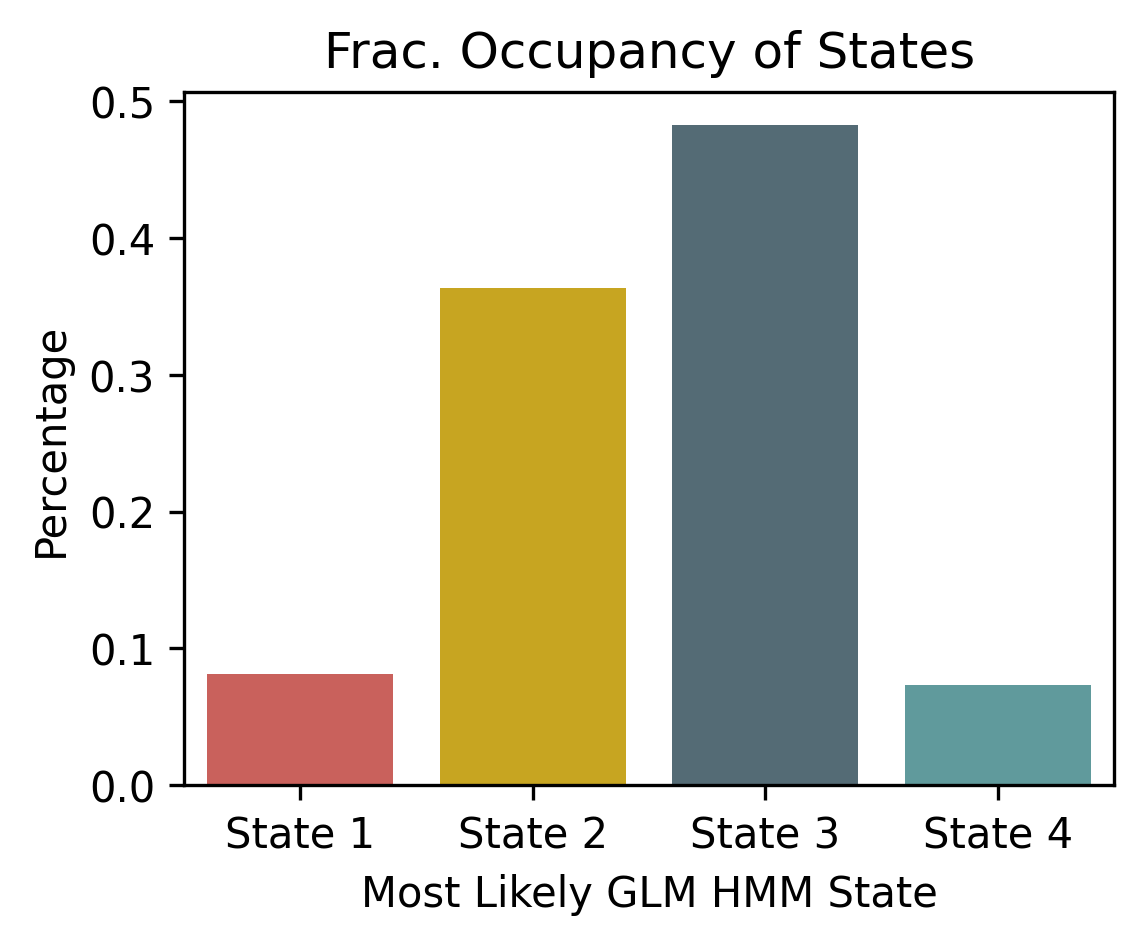

In [ ]:
# Calculate the count of each state and divide by the total to get the percentage
adf['state_percentage'] = adf['most_likely_state'].map(adf['most_likely_state'].value_counts(normalize=True))

# Plotting
plt.figure(figsize=(4, 3), dpi=300)
ax = sns.barplot(data=adf, x='most_likely_state', y='state_percentage', palette=cmap, order=['state_1', 'state_2', 'state_3', 'state_4'])

# Customize x-axis labels
new_labels = ['State 1', 'State 2', 'State 3', 'State 4']
ax.set_xticklabels(new_labels)

plt.xlabel('Most Likely GLM HMM State')
plt.ylabel('Percentage')
plt.title('Frac. Occupancy of States')
plt.show()


In [97]:
adf['most_likely_state'].value_counts(normalize=True)

most_likely_state
state_3    0.482411
state_2    0.363505
state_1    0.081108
state_4    0.072977
Name: proportion, dtype: float64

In [118]:
# Frame prediction counts are [still, move, wheel_turn, groom]
# Now we want to see the probability of [still, move, wheel_turn, groom] as a function of GLM HMM state

state_frame_probs=[]

for i, state in enumerate(['state_1', 'state_2', 'state_3', 'state_4']):
    
    state_data = adf[adf['most_likely_state'] == state]


    all_still = state_data['still'].sum()
    all_move = state_data['move'].sum()
    all_wheel_turn = state_data['wheel_turn'].sum()
    all_groom = state_data['groom'].sum()
    
    total_count = all_still + all_move + all_wheel_turn + all_groom

    state_frame_probs.append(np.array([all_still, all_move, all_wheel_turn, all_groom]) / total_count)

np.array(state_frame_probs)

array([[0.76493739, 0.08237523, 0.14190611, 0.01078127],
       [0.741466  , 0.09667237, 0.15280395, 0.00905767],
       [0.72329971, 0.10086707, 0.16554673, 0.01028649],
       [0.78972749, 0.07285349, 0.12966184, 0.00775718]])

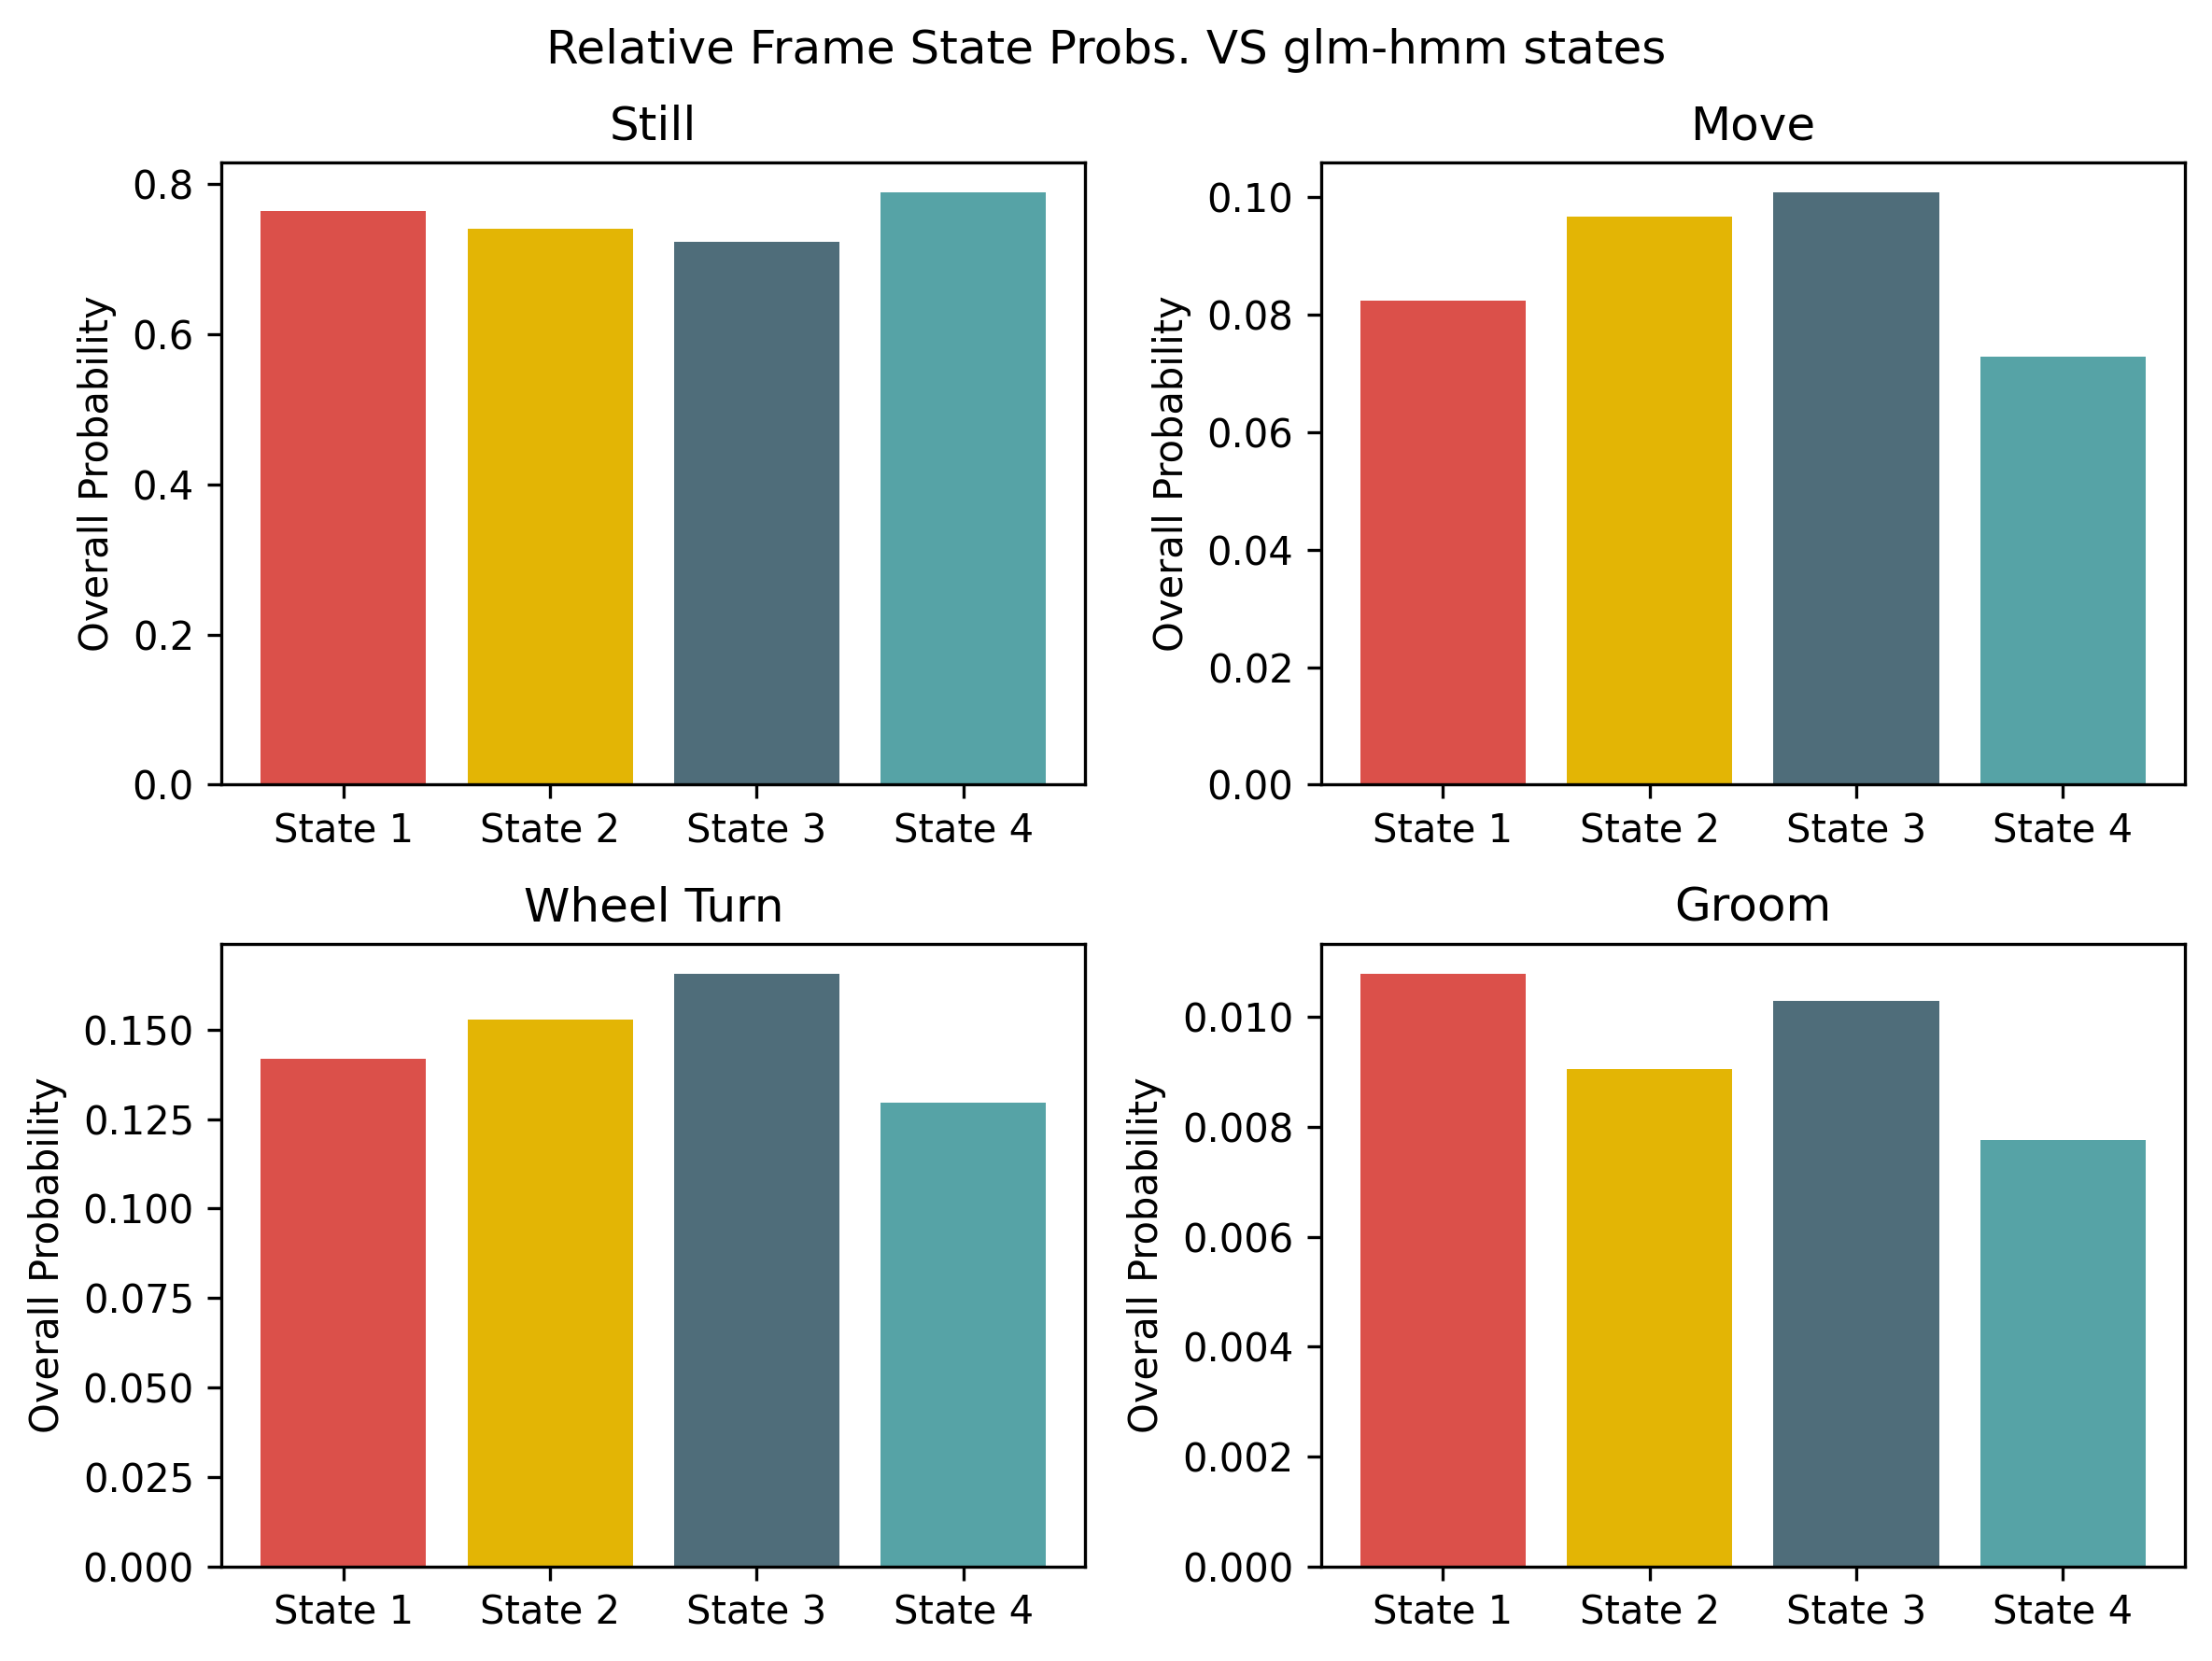

In [176]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)

probs = np.array(state_frame_probs).T

for i, frame in enumerate(['Still', 'Move', 'Wheel Turn', 'Groom']):
    ax[i//2, i%2].bar(['State 1', 'State 2', 'State 3', 'State 4'], probs[i], color=cmap)
    ax[i//2, i%2].set_title(frame)
    ax[i//2, i%2].set_ylabel('Overall Probability')

plt.tight_layout()
plt.suptitle('Relative Frame State Probs. VS glm-hmm states')
plt.subplots_adjust(top=0.9)
plt.show()

In [161]:
np.array(state_frame_probs).T

array([[0.76493739, 0.741466  , 0.72329971, 0.78972749],
       [0.08237523, 0.09667237, 0.10086707, 0.07285349],
       [0.14190611, 0.15280395, 0.16554673, 0.12966184],
       [0.01078127, 0.00905767, 0.01028649, 0.00775718]])

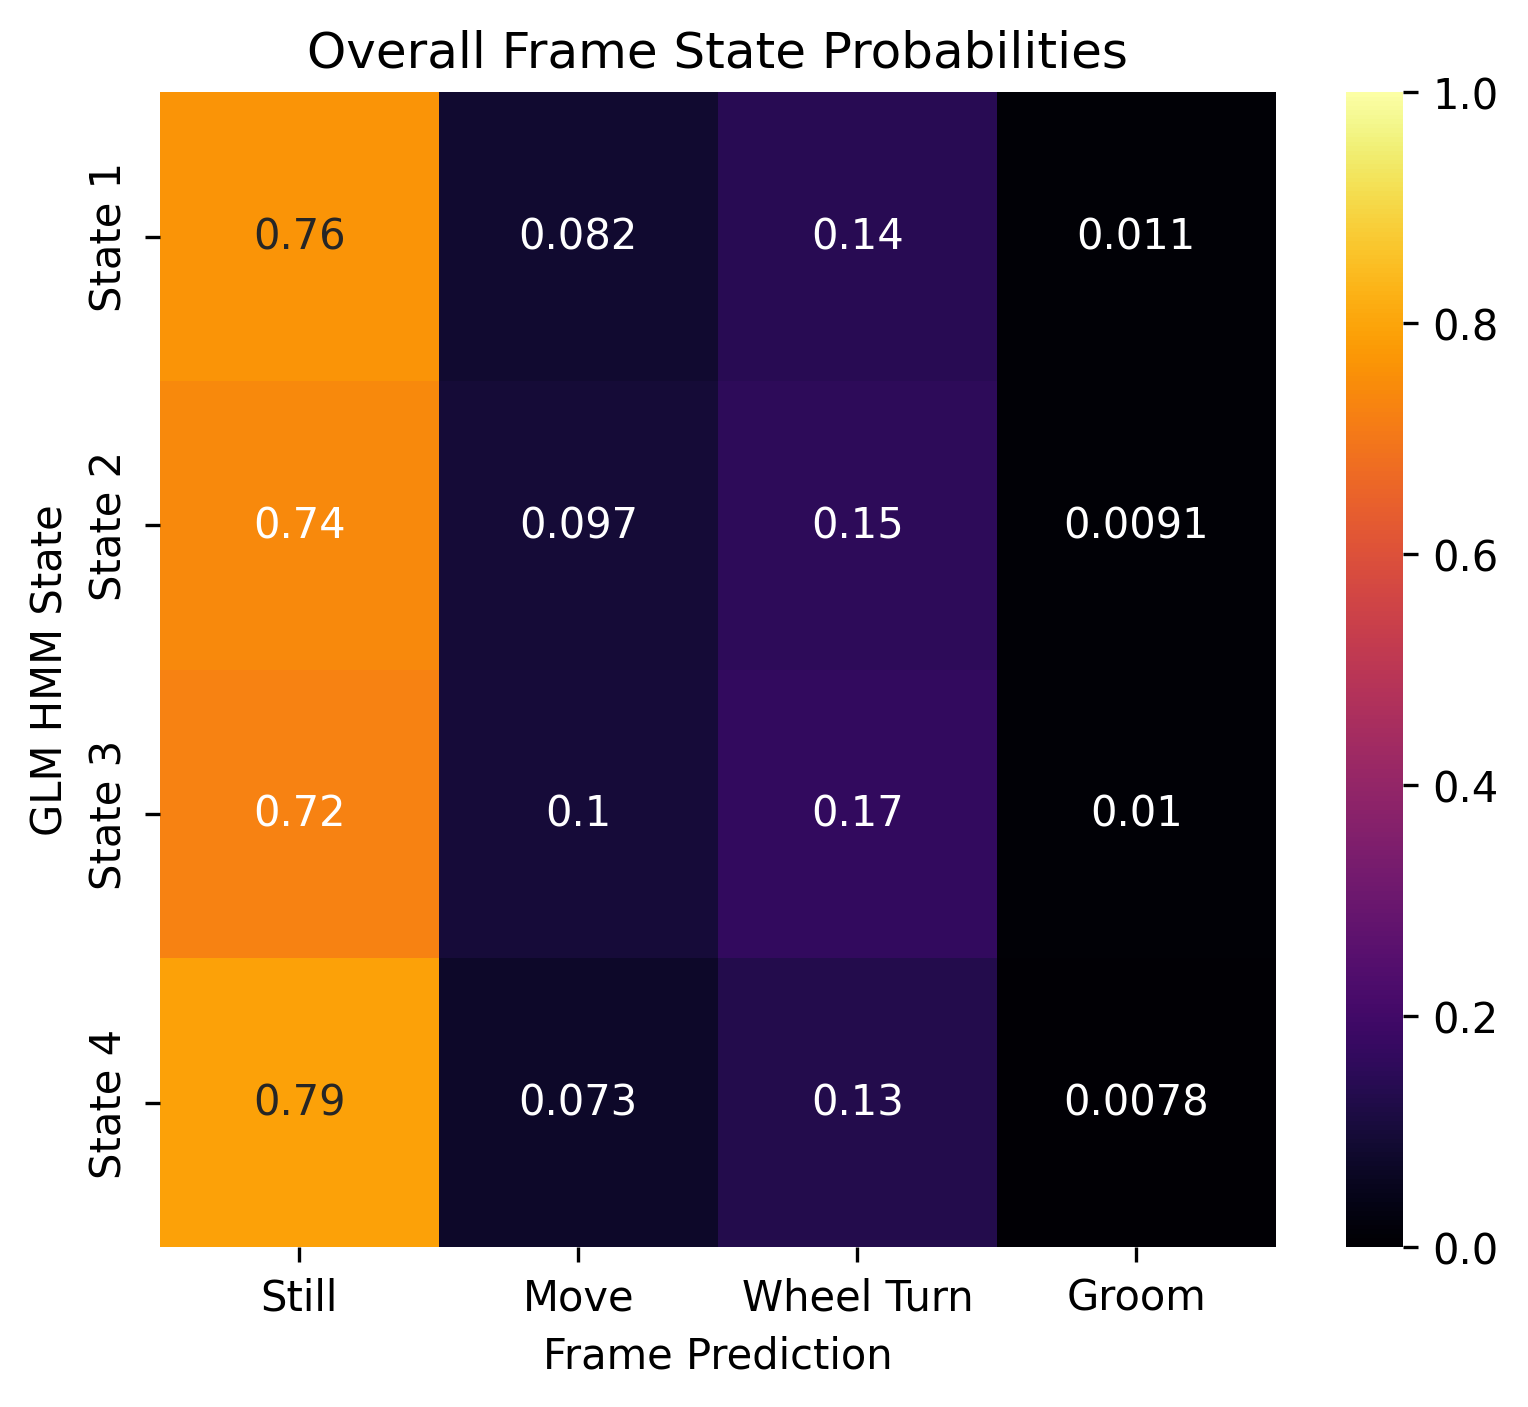

In [173]:
probs = np.array(state_frame_probs)
plt.figure(figsize=(6, 5), dpi=300)
ax = sns.heatmap(
    probs, 
    cmap='inferno', 
    annot=True, 
    yticklabels=['State 1', 'State 2', 'State 3', 'State 4'], 
    xticklabels=['Still', 'Move', 'Wheel Turn', 'Groom'],
    vmin=0, 
    vmax=1,
    )

# 45 degree rotation of the x-axis labels
# plt.xticks(rotation=15)
plt.xlabel('Frame Prediction')
plt.ylabel('GLM HMM State')
plt.title('Overall Frame State Probabilities')
plt.show()

In [ ]:
probs = np.sort(np.array(state_frame_probs).T, axis=0)
plt.figure(figsize=(6, 5), dpi=300)
ax = sns.heatmap(
    probs, 
    cmap='inferno', 
    annot=True, 
    xticklabels=['State 1', 'State 2', 'State 3', 'State 4'], 
    yticklabels=['Still', 'Move', 'Wheel Turn', 'Groom'],
    vmin=0, 
    vmax=1,
    )

# 45 degree rotation of the x-axis labels
plt.xticks(rotation=25)
plt.xlabel('Frame Prediction')
plt.ylabel('GLM HMM State')
plt.title('Frame State Probability')